In [34]:
#1-1 Case 1: Only Detecting Vehicle(Project 5)
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    data_dict["max_value"] = np.max(example_img)
    data_dict["min_value"] = np.min(example_img)
    # Return data_dict
    return data_dict

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    print("Images is converted to ",color_space)
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'        
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)             

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, box_list, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    #draw_img = np.copy(img)
    img = img.astype(np.float32)/255    
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))                
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)     
    return box_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        # Input Text on top of the box
        cv2.rectangle(img, (bbox[0][0],bbox[0][1]-40), (bbox[0][0]+75,bbox[0][1]), (0,0,255), -1)
        cv2.putText(img,"Car",(bbox[0][0]+5,bbox[0][1]-12), cv2.FONT_HERSHEY_SIMPLEX, 1.2,(255,255,255),2)
    # Return the image
    return img

def start(img):                   
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    box_list=[]
    scalelist = [1,1.5,2]    
    for scale in scalelist:
        if(scale==1):            
            ystart = 400
            ystop = 500
        elif(scale==1.5):
            ystart = 400
            ystop = 600 
        else:
            ystart = 400
            ystop = 656
        box_list = find_cars(img, box_list, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)        
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)            
    return draw_img

In [10]:
#1-2 Extract features from training images for Case 1
import glob
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
import time
import pickle
%matplotlib inline

cars = glob.glob('vehicles/**/*.png')
notcars = glob.glob('non-vehicles/**/*.png')

#Parameters to extract features
color_space = 'YCrCb'
spatial_size = (32, 32)
hist_bins = 32    
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_feat = True
hog_feat = True
hist_feat = True

print("Extracting features from training images..")
if os.path.isfile('car_features.pickle'):
    with open('car_features.pickle', 'rb') as handle:
        data = pickle.load(handle)
        car_features, notcar_features = data['car'], data['notcar']
else:
    t=time.time()
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)    
    data = {'car':car_features,'notcar':notcar_features}
    with open('car_features.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract features...')
        
#Normalizing training images
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print("Shape of scaled_X :",scaled_X.shape)
print("Shape of Y : ",y.shape)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', 
      cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
print("X_train: ",X_train.shape)
print("y_train: ",y_train.shape)
print("X_test: ",X_test.shape)
print("y_test: ",y_test.shape)

# Use a linear SVC as a classifier
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


Extracting features from training images..
Shape of scaled_X : (17760, 8460)
Shape of Y :  (17760,)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
X_train:  (14208, 8460)
y_train:  (14208,)
X_test:  (3552, 8460)
y_test:  (3552,)
6.26 Seconds to train SVC...
Test Accuracy of SVC =  0.991


TypeError: Image data can not convert to float

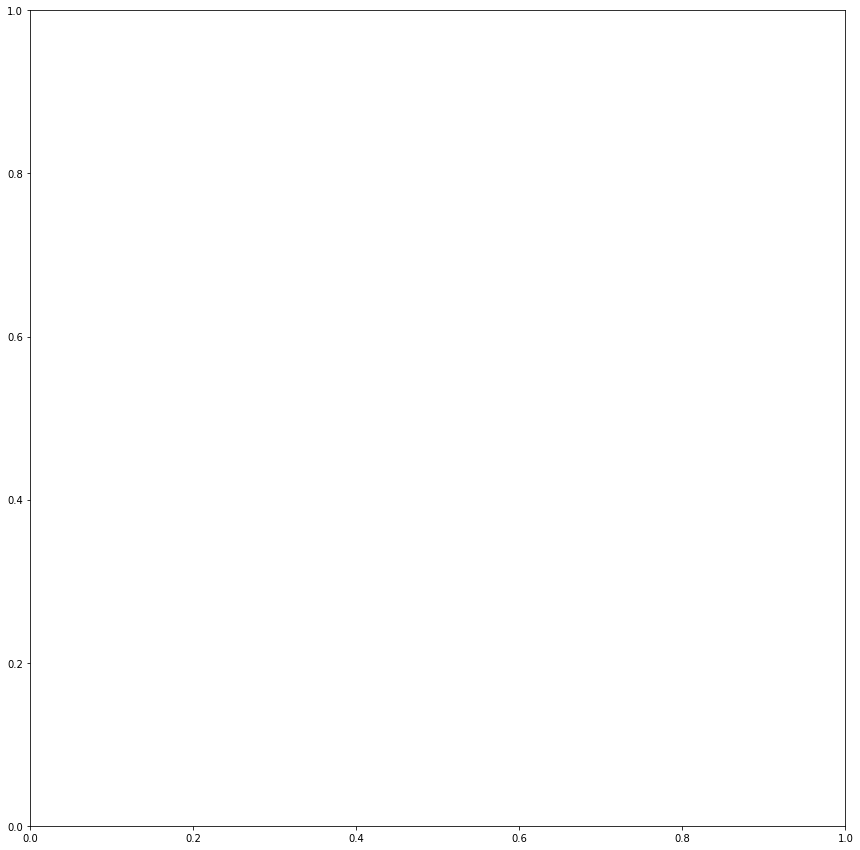

In [36]:
test_img = glob.glob('test_images/*.jpg')
for num,img in enumerate(test_img): 
    img = mpimg.imread(img)
    draw_img = start(img)    
    fig, axes = plt.subplots(1,1, figsize=(15,15))            
    cv2.imwrite('output_images/window'+str(num)+'.jpg',draw_img)
    axes.imshow(draw_img)

Test Image size:  (720, 1280, 3)
Test Image data type:  uint8
Test Image[0] value range between  0  and  255


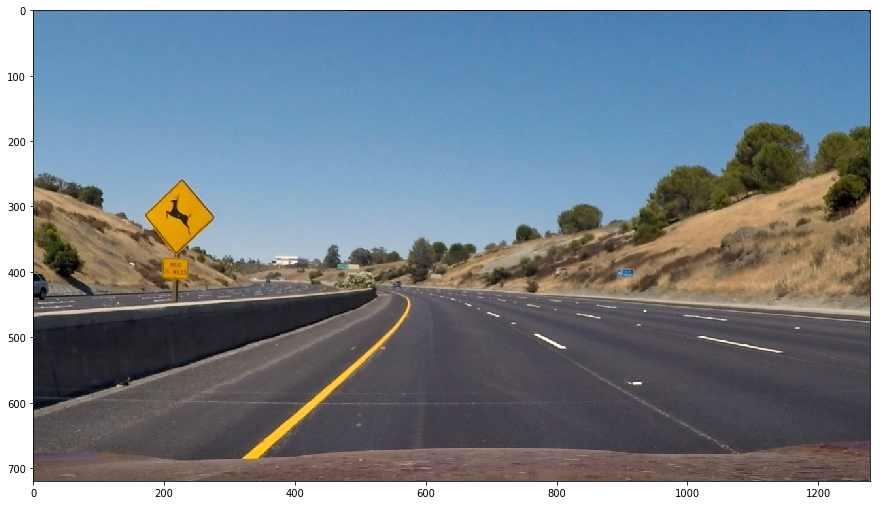

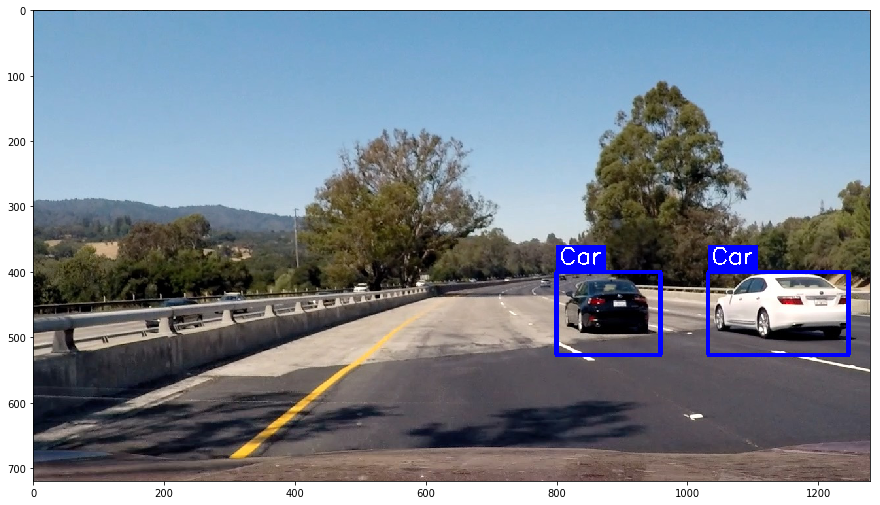

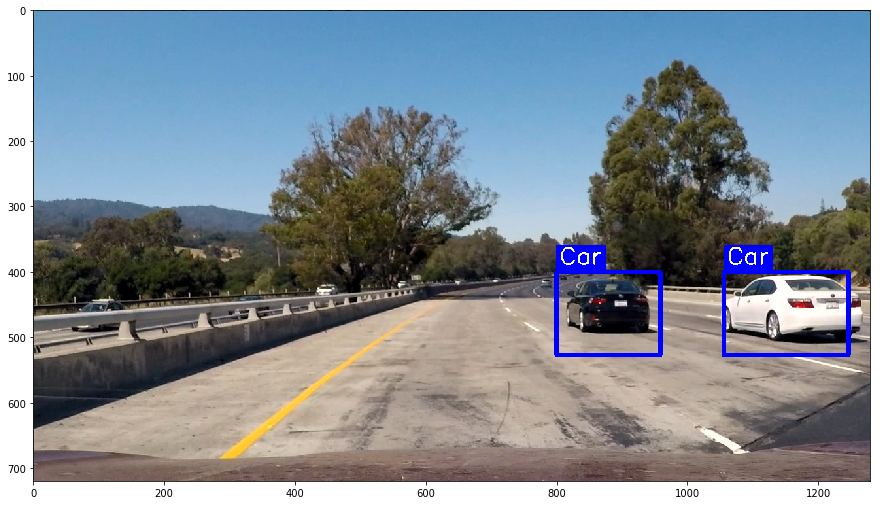

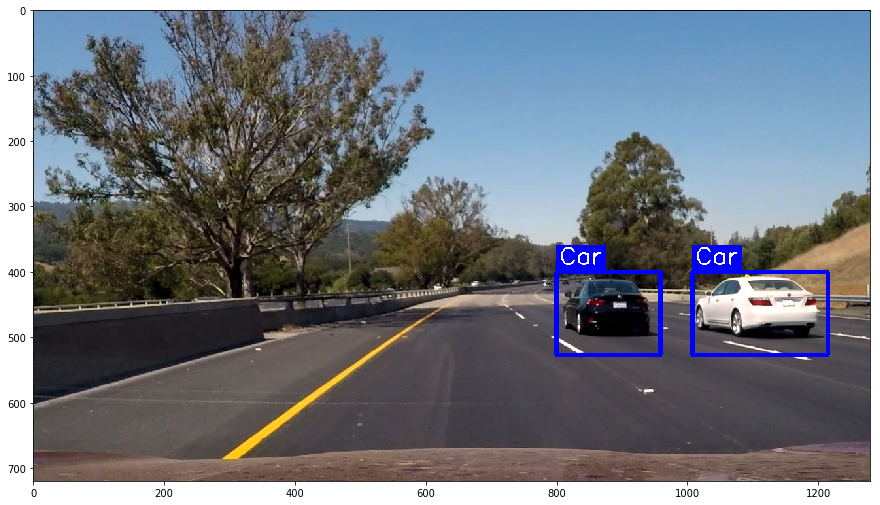

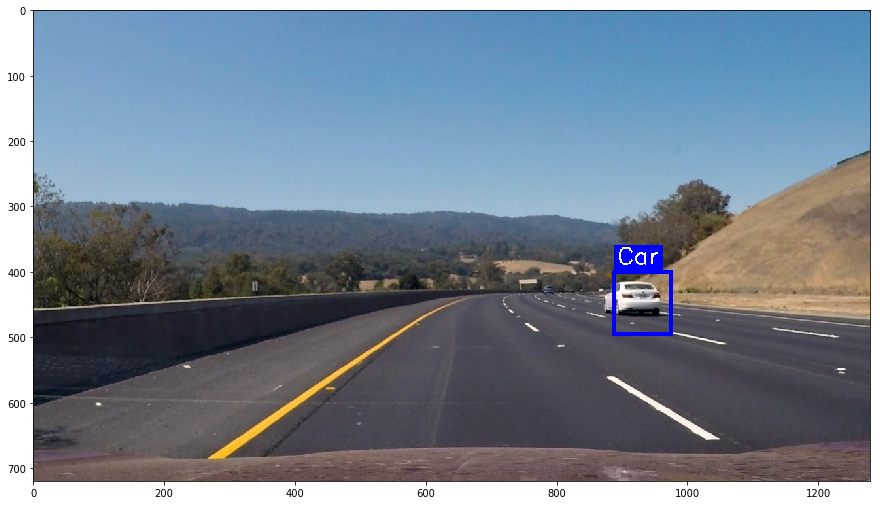

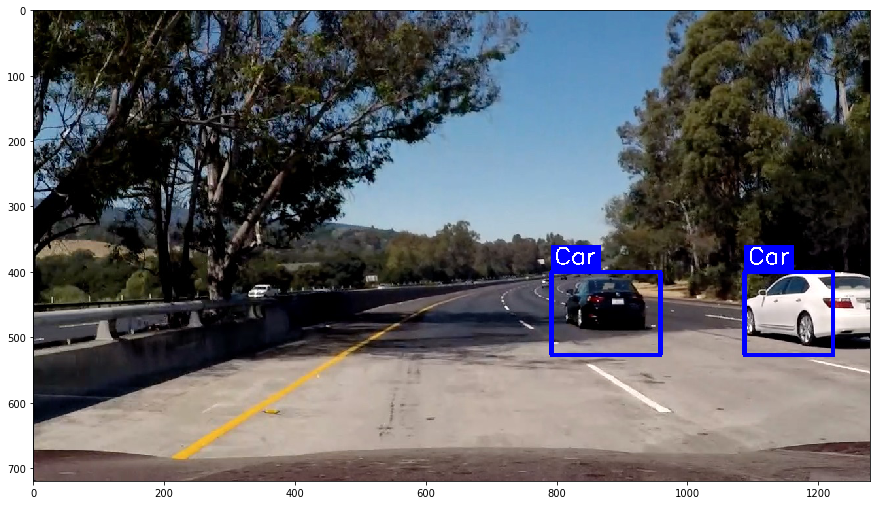

In [11]:
#1-3 Test with Images for Case 1

test_img = glob.glob('test_images/*.jpg')
data_info = data_look(test_img,[])
print('Test Image size: ',data_info["image_shape"])
print('Test Image data type: ',data_info["data_type"])
print('Test Image[0] value range between ',data_info["min_value"],' and ',data_info["max_value"])

for img in test_img: 
    img = mpimg.imread(img)
    draw_img = start(img)    
    fig, axes = plt.subplots(1,1, figsize=(15,15))            
    axes.imshow(draw_img)

In [ ]:
#1-4(Case 1 Finish) Making Movie Clip for Case 1

from moviepy.editor import VideoFileClip
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from P4_Lane_Detection import Line

clip = VideoFileClip("project_video.mp4")
output ="project_video_output.mp4"
output_clip = clip.fl_image(start)
%time output_clip.write_videofile(output, audio=False)

In [24]:
#2-1 Case 2(Opt): Combine Detecting Adv.Lane(Project 4) and Detecting Vehicle(Project 5)

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt    
import glob
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
import time
from skimage.feature import hog
import matplotlib.image as mpimg
from scipy.ndimage.measurements import label
import pickle
%matplotlib inline

class Line_Vehicle():    
    def __init__(self):
        ####################
        #For Line detecting#
        ####################
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = None
        #average x values of the fitted line over the last n iterations
        self.bestx = [[],[]] 
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = np.zeros((2, 3)) 
        #polynomial coefficients for the most recent fit
        self.current_fit = np.zeros((2, 3))
        #radius of curvature of the line in some units
        self.radius_of_curvature = np.zeros((2, 1))     
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = [np.array([0,0,0]),np.array([0,0,0])]
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None        
        #number of continuous error frames
        self.errorCount =0
        #to keep previous warp image
        self.newwarp=None
        #Curvature and offset
        self.curvature = None
        self.offset =None

        #######################
        #For Vehicle Detecting#
        #######################
        self.color_space = 'YCrCb'
        self.spatial_size = (32, 32)
        self.hist_bins = 32    
        self.orient = 9
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
        self.spatial_feat = True
        self.hog_feat = True
        self.hist_feat = True
        
        #Extract features from training images
        print("Extracting features from training images..")
        if os.path.isfile('car_features.pickle'):
            with open('car_features.pickle', 'rb') as handle:
                data = pickle.load(handle)
                car_features, notcar_features = data['car'], data['notcar']
        else:
            t=time.time()
            car_features = extract_features(cars, color_space=color_space, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                    hist_feat=hist_feat, hog_feat=hog_feat)
            notcar_features = extract_features(notcars, color_space=color_space, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                    hist_feat=hist_feat, hog_feat=hog_feat)    
            data = {'car':car_features,'notcar':notcar_features}
            with open('car_features.pickle', 'wb') as handle:
                pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
            t2 = time.time()
            print(round(t2-t, 2), 'Seconds to extract features...')

        #Normalizing training images
        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        # Fit a per-column scaler
        self.X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)
        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
        print("Shape of scaled_X :",scaled_X.shape)
        print("Shape of Y : ",y.shape)

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.2, random_state=rand_state)

        print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', 
              cell_per_block,'cells per block')
        print('Feature vector length:', len(X_train[0]))
        print("X_train: ",X_train.shape)
        print("y_train: ",y_train.shape)
        print("X_test: ",X_test.shape)
        print("y_test: ",y_test.shape)

        # Use a linear SVC as a classifier
        self.svc = LinearSVC()
        t=time.time()
        svc.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')
        # Check the score of the SVC
        print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
        
    ############################        
    #Lane Detecting Methods(P4)#
    ############################
    def calibration(self, path):
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
        # Arrays to store object points and image points from all the images.
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.
        # Make a list of calibration images
        images = glob.glob(path)
        retTrue_images=[]
        corner_images = []
        undist_images=[]
        counter =0
        # Step through the list and search for chessboard corners and undistort images
        for num in range(len(images)):
            img = cv2.imread(images[num])            
            img_size = (img.shape[1], img.shape[0])
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)    
            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6),None)     
            # If found, add object points, image points    
            if ret == True:                        
                objpoints.append(objp)
                imgpoints.append(corners)        
            else:
                counter+=1        
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
        self.mtx = mtx
        self.dist = dist
        print(str(counter)+" of "+str(len(images))+" failed to find corners for 9x6 chessboard")        

    def undistort(self, img):
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)               
          
    def abs_sobel_thresh(self, img, orient='x', sobel_kernel=3, thresh=(0, 200)):    
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
        if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # Create a copy and apply the threshold
        binary_output = np.zeros_like(scaled_sobel)
        # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

        # Return the result
        return binary_output

    def mag_thresh(self,img, sobel_kernel=3, mag_thresh=(0, 255)):    
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

        # Return the binary image
        return binary_output

    def dir_threshold(self,img, sobel_kernel=3, thresh=(0, np.pi/2)):    
        # Calculate the x and y gradients
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Take the absolute value of the gradient direction, 
        # apply a threshold, and create a binary image result
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

        # Return the binary image
        return binary_output

    def s_threshold(self,img, thresh=(0,255)):
        binary_output = np.zeros_like(img)
        binary_output[(img >= thresh[0]) & (img <= thresh[1])] = 1
        return binary_output

    def binary(self, img):
        ksize = 7
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
        l_channel = hsv[:,:,1]
        s_channel = hsv[:,:,2]
        gradx = self.abs_sobel_thresh(l_channel, orient='x', sobel_kernel=ksize, thresh=(55, 100))
        grady = self.abs_sobel_thresh(l_channel, orient='y', sobel_kernel=ksize, thresh=(30, 100))
        mag_binary = self.mag_thresh(l_channel, sobel_kernel=ksize, mag_thresh=(30, 100))
        dir_binary = self.dir_threshold(l_channel, sobel_kernel=ksize, thresh=((0.8, 1.1)))
        s_binary = self.s_threshold(s_channel, thresh=((170,215)))
        combined = np.zeros_like(l_channel)
        combined[((gradx == 1) & (grady == 1)) |
                 ((mag_binary == 1) & (dir_binary == 1)) |
                 (s_binary==1)] = 1    
        return combined    
    
    def transform(self, img):
        img_size = (img.shape[1], img.shape[0])
        src = np.float32([[592,450],[260,680],[1057,680],[691,450]])
        dst = np.float32([[(img_size[0] / 4), 0],
                          [(img_size[0] / 4), img_size[1]],
                          [(img_size[0] * 3 / 4), img_size[1]],
                          [(img_size[0] * 3 / 4), 0]])
        M = cv2.getPerspectiveTransform(src, dst)
        return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    def findLane(self, binary_warped):            
        # Create an output image to draw on and  visualize the result        
        out_img = np.dstack((binary_warped, binary_warped, binary_warped)) 
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])  
        # Set the width of the windows +/- margin
        margin = 100

        if self.detected == True:
            left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
            right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
        else:
            self.errorCount+=1
            # Take a histogram of the bottom half of the image            
            histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)    
            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]/2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint
            # Choose the number of sliding windows
            nwindows = 9
            # Set height of windows
            window_height = np.int(binary_warped.shape[0]/nwindows)
            # Current positions to be updated for each window
            leftx_current = leftx_base
            rightx_current = rightx_base

            # Set minimum number of pixels found to recenter window
            minpix = 50
            # Create empty lists to receive left and right lane pixel indices
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                # Draw the windows on the visualization image
                #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,1,0), 2) 
                #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,1,0), 2) 
                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
            self.detected == True

        #x,y values for detected line pixels                
        self.allx = [np.array(nonzerox[left_lane_inds]),np.array(nonzerox[right_lane_inds])]
        self.ally = [np.array(nonzeroy[left_lane_inds]),np.array(nonzeroy[right_lane_inds])]
        #polynomial coefficients for the most recent fit / 0:left, 1:right
        self.current_fit[0] = np.polyfit(self.ally[0],self.allx[0], 2)        
        self.current_fit[1] = np.polyfit(self.ally[1],self.allx[1], 2)
        
        # x values of the last n fits of the line
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
   
        #average x values of the fitted line over the last n iterations  
        n = 15 #Number of the iteration to average the array                
        if self.recent_xfitted is not None:            
            if self.recent_xfitted[0].shape[0] == n:                
                self.recent_xfitted[0] = np.delete(self.recent_xfitted[0],0,axis=0)
                self.recent_xfitted[1] = np.delete(self.recent_xfitted[1],0,axis=0)
            self.recent_xfitted[0] = np.vstack((self.recent_xfitted[0],
                       (self.current_fit[0][0]*ploty**2 + 
                       self.current_fit[0][1]*ploty + 
                       self.current_fit[0][2])))
            self.recent_xfitted[1] = np.vstack((self.recent_xfitted[1],
                       (self.current_fit[1][0]*ploty**2 + 
                       self.current_fit[1][1]*ploty + 
                       self.current_fit[1][2])))
                             
            self.bestx = [np.mean(self.recent_xfitted[0],axis=0),np.mean(self.recent_xfitted[1],axis=0)]
        else:
            self.recent_xfitted = [((np.array(self.current_fit[0][0]*ploty**2 + 
                                             self.current_fit[0][1]*ploty + 
                                             self.current_fit[0][2]))),
                                   ((np.array(self.current_fit[1][0]*ploty**2 + 
                                             self.current_fit[1][1]*ploty + 
                                             self.current_fit[1][2])))]
            self.bestx = [self.recent_xfitted[0],self.recent_xfitted[1]]
           
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = [np.polyfit(ploty,self.bestx[0], 2),np.polyfit(ploty,self.bestx[1], 2)        ]
        
        #difference in fit coefficients between last and new fits
        self.diffs = [abs(np.subtract(self.best_fit[0],self.current_fit[0])),
                      abs(np.subtract(self.best_fit[1],self.current_fit[1]))]     
        
        self.measure_curvature_offset(ploty)
                
        # Sanity Check
        if self.sanityCheck()==True:
            out_img[self.ally[0], self.allx[0]] = [1, 0, 0]
            out_img[self.ally[1], self.allx[1]] = [0, 0, 1]
            color_warp = np.zeros_like(out_img).astype(np.uint8)
            
            # Recast the x and y points into usable format for cv2.fillPoly()
            pts_left = np.array([np.transpose(np.vstack([self.bestx[0], ploty]))])
            pts_right = np.array([np.flipud(np.transpose(np.vstack([self.bestx[1], ploty])))])
            pts = np.hstack((pts_left, pts_right))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
            color_warp = cv2.addWeighted(color_warp,1,(out_img*255).astype(np.uint8),1,0)

            # Warp the blank back to original image space using inverse perspective matrix (Minv)
            self.newwarp = self.inv_transform(color_warp)
            
            # Combine the result with the original image
            result = cv2.addWeighted(cv2.cvtColor(self.undistort_img, cv2.COLOR_BGR2RGB), 1, self.newwarp, 0.3, 0)
        
            # Information box            
            self.curvature = 'Radius of Curvature = '+str(np.round(np.mean([self.radius_of_curvature[0],self.radius_of_curvature[1]]),1))+'(m)'
            
            if self.line_base_pos>=0:
                self.offset = 'Vehicle is '+str(self.line_base_pos)+'m right of the center'
            else:
                self.offset = 'Vehicle is '+str(-self.line_base_pos)+'m left of the center'

            cv2.rectangle(result, (8,25),(600,90), (0,0,0), -1)
            cv2.putText(result,self.curvature,(10,50), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
            cv2.putText(result,self.offset,(10,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)                                    
            return result        
        else:
            self.detected == False            
            #remove last fitted values from the bestx array unless there are no values, 720 means (720,) - one row
            if self.recent_xfitted[0].shape[0]!=720:
                self.recent_xfitted[0] = np.delete(self.recent_xfitted[0],-1,axis=0)
                self.recent_xfitted[1] = np.delete(self.recent_xfitted[1],-1,axis=0)                        
            self.errorCount+=1
            if self.errorCount ==1:
                self.findLane(binary_warped)
            # Less than 10 error frames / keep previous information
            elif self.errorCount <10: 
                if self.newwarp==None:
                    result = cv2.cvtColor(self.undistort_img, cv2.COLOR_BGR2RGB)
                else:
                    result = cv2.addWeighted(cv2.cvtColor(self.undistort_img, cv2.COLOR_BGR2RGB), 1, self.newwarp, 0.3, 0)                                
                cv2.rectangle(result, (8,25),(600,90), (0,0,0), -1)
                cv2.putText(result,self.curvature,(10,50), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
                cv2.putText(result,self.offset,(10,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)                                    
                return result
            # More than 10 error frames / show error / initialize previous x values
            else : 
                self.errorCount = 0
                self.recent_xfitted = None
                self.diffs = [np.array([0,0,0]),np.array([0,0,0])]
                if self.newwarp==None:
                    result = cv2.cvtColor(self.undistort_img, cv2.COLOR_BGR2RGB)
                else:
                    result = cv2.addWeighted(cv2.cvtColor(self.undistort_img, cv2.COLOR_BGR2RGB), 1, self.newwarp, 0.3, 0)                                
                self.curvature = "Cannot find lane"
                cv2.rectangle(result, (8,25),(600,90), (0,0,0), -1)                
                cv2.putText(result,self.curvature,(10,50), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)                
                return result
                      
    def measure_curvature_offset(self, ploty):
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        y_eval = np.max(ploty)

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, self.bestx[0]*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, self.bestx[1]*xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        self.radius_of_curvature[0] = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        self.radius_of_curvature[1] = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])            
        self.line_base_pos = np.round(((((self.bestx[1][0]+self.bestx[0][0])/2)-(self.undistort_img.shape[1]/2))*xm_per_pix),1)        

    def inv_transform(self, img):
        img_size = (img.shape[1], img.shape[0])
        dst = np.float32([[592,450],[260,680],[1057,680],[691,450]])
        src = np.float32([[(img_size[0] / 4), 0],
                          [(img_size[0] / 4), img_size[1]],
                          [(img_size[0] * 3 / 4), img_size[1]],
                          [(img_size[0] * 3 / 4), 0]])
        M = cv2.getPerspectiveTransform(src, dst)
        return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    def sanityCheck(self):
        straight_flag = False
        #Checking that they have similar curvature
        if self.radius_of_curvature[0]>3000 or self.radius_of_curvature[0]>3000:
            # Since straight lane is very sensetive, ignore big value
            straight_flag = True            
        elif abs(self.radius_of_curvature[0]-self.radius_of_curvature[1])>500:
            print("Both curvature are not similar")
            print("Left: "+str(self.radius_of_curvature[0]))
            print("Right: "+str(self.radius_of_curvature[1]))
            return False
                    
        #Checking that they are separated by approximately the right distance horizontally
        if abs(self.line_base_pos)>3:
            print("Line_base_pos is separated from the center more than 3")
            print("Base position: "+str(self.line_base_pos))            
            return False
        
        #Checking that they are roughly parallel        
        if straight_flag == False:                    
            if self.diffs[0][1]-self.diffs[0][1]>5:
                pritn("Both lanes are not parallel")            
                print("Left difference: "+self.diffs[0])
                print("Right difference: "+self.diffs[1])
                return False        
        
        return True  
    
    #batch method
    def lane_start(self, img):         
        self.undistort_img = self.undistort(img)
        binary = self.binary(self.undistort_img)
        binary_warped = self.transform(binary)
        result = self.findLane(binary_warped)
        return cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    ###############################
    #Vehicle Detecting Methods(P5)#
    ###############################
    # Define a function to return some characteristics of the dataset 
    def data_look(self, car_list, notcar_list):
        data_dict = {}
        # Define a key in data_dict "n_cars" and store the number of car images
        data_dict["n_cars"] = len(car_list)
        # Define a key "n_notcars" and store the number of notcar images
        data_dict["n_notcars"] = len(notcar_list)
        # Read in a test image, either car or notcar
        example_img = mpimg.imread(car_list[0])
        # Define a key "image_shape" and store the test image shape 3-tuple
        data_dict["image_shape"] = example_img.shape
        # Define a key "data_type" and store the data type of the test image.
        data_dict["data_type"] = example_img.dtype
        data_dict["max_value"] = np.max(example_img)
        data_dict["min_value"] = np.min(example_img)
        # Return data_dict
        return data_dict

    def convert_color(self, img, conv='RGB2YCrCb'):
        if conv == 'RGB2YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        if conv == 'BGR2YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        if conv == 'RGB2LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


    def get_hog_features(self, img, orient, pix_per_cell, cell_per_block, 
                            vis=False, feature_vec=True):
        # Call with two outputs if vis==True
        if vis == True:
            features, hog_image = hog(img, orientations=orient, 
                                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block), 
                                      transform_sqrt=False, 
                                      visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        # Otherwise call with one output
        else:      
            features = hog(img, orientations=orient, 
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), 
                           transform_sqrt=False, 
                           visualise=vis, feature_vector=feature_vec)
            return features

    def extract_features(self, imgs, color_space='RGB', spatial_size=(32, 32),
                            hist_bins=32, orient=9, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=0,
                            spatial_feat=True, hist_feat=True, hog_feat=True):
        # Create a list to append feature vectors to
        features = []
        # Iterate through the list of images
        print("Images is converted to ",color_space)
        for file in imgs:
            file_features = []
            # Read in each one by one
            image = mpimg.imread(file)
            # apply color conversion if other than 'RGB'        
            if color_space != 'RGB':
                if color_space == 'HSV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                elif color_space == 'LUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                elif color_space == 'HLS':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                elif color_space == 'YUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                elif color_space == 'YCrCb':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            else: feature_image = np.copy(image)             

            if spatial_feat == True:
                spatial_features = self.bin_spatial(feature_image, size=spatial_size)
                file_features.append(spatial_features)
            if hist_feat == True:
                # Apply color_hist()
                hist_features = self.color_hist(feature_image, nbins=hist_bins)
                file_features.append(hist_features)
            if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                            orient, pix_per_cell, cell_per_block, 
                                            vis=False, feature_vec=True))
                    hog_features = np.ravel(hog_features)        
                else:
                    hog_features = self.get_hog_features(feature_image[:,:,hog_channel], orient, 
                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                # Append the new feature vector to the features list
                file_features.append(hog_features)
            features.append(np.concatenate(file_features))
        # Return list of feature vectors
        return features

    def bin_spatial(self, img, size=(32, 32)):
        color1 = cv2.resize(img[:,:,0], size).ravel()
        color2 = cv2.resize(img[:,:,1], size).ravel()
        color3 = cv2.resize(img[:,:,2], size).ravel()
        return np.hstack((color1, color2, color3))

    def color_hist(self, img, nbins=32):    #bins_range=(0, 256)
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=nbins)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features

    # Define a single function that can extract features using hog sub-sampling and make predictions
    def find_cars(self, img, box_list, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):

        #draw_img = np.copy(img)
        img = img.astype(np.float32)/255    

        img_tosearch = img[ystart:ystop,:,:]
        ctrans_tosearch = self.convert_color(img_tosearch, conv='RGB2YCrCb')
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell)-1
        nyblocks = (ch1.shape[0] // pix_per_cell)-1 
        nfeat_per_block = orient*cell_per_block**2
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell)-1 
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = self.get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = self.get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = self.get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = self.bin_spatial(subimg, size=spatial_size)
                hist_features = self.color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))                
                    #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)     
        return box_list

    def add_heat(self, heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        # Return updated heatmap
        return heatmap# Iterate through list of bboxes

    def apply_threshold(self, heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap

    def draw_labeled_bboxes(self, img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))        
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
            # Input Text on top of the box
            cv2.rectangle(img, (bbox[0][0],bbox[0][1]-40), (bbox[0][0]+75,bbox[0][1]), (0,0,255), -1)
            cv2.putText(img,"Car",(bbox[0][0]+5,bbox[0][1]-12), cv2.FONT_HERSHEY_SIMPLEX, 1.2,(255,255,255),2)
        # Return the image
        return img

    def vehicle_start(self, img, draw_img):                   
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        box_list=[]
        scalelist = [1,1.5,2]    
        for scale in scalelist:
            if(scale==1):            
                ystart = 400
                ystop = 500
            elif(scale==1.5):
                ystart = 400
                ystop = 600 
            else:
                ystart = 400
                ystop = 656
            box_list = self.find_cars(img, box_list, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)        
        # Add heat to each box in box list
        heat = self.add_heat(heat,box_list)    
        # Apply threshold to help remove false positives
        heat = self.apply_threshold(heat,1)
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        # Find final boxes from heatmap using label function        
        labels = label(heatmap)
        draw_img = self.draw_labeled_bboxes(draw_img, labels)            
        return draw_img    
    
    def start(self, img):
        draw_img = np.copy(img)
        draw_img = self.lane_start(draw_img)
        result = self.vehicle_start(img,draw_img)
        return result

In [25]:
#2-2 Test with Images for Case 2
import os.path

obj = Line_Vehicle()
test_img = glob.glob('test_images/*.jpg')
data_info = data_look(test_img,[])
print('Test Image size: ',data_info["image_shape"])
print('Test Image data type: ',data_info["data_type"])
print('Test Image[0] value range between ',data_info["min_value"],' and ',data_info["max_value"])

if os.path.isfile('mtx_dist.pickle'):
    with open('mtx_dist.pickle', 'rb') as handle:
        data = pickle.load(handle)
        obj.mtx, obj.dist = data['mtx'], data['dist']
else:
    obj.calibration('camera_cal/calibration*.jpg')
    data = {'mtx':obj.mtx,'dist':obj.dist}
    with open('mtx_dist.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

Extracting features from training images..
Shape of scaled_X : (17760, 8460)
Shape of Y :  (17760,)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
X_train:  (14208, 8460)
y_train:  (14208,)
X_test:  (3552, 8460)
y_test:  (3552,)
28.14 Seconds to train SVC...
Test Accuracy of SVC =  0.9916
Test Image size:  (720, 1280, 3)
Test Image data type:  uint8
Test Image[0] value range between  0  and  255


Both curvature are not similar
Left: [ 1884.49596891]
Right: [ 884.45044617]


/home/hyukpyohong/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:391: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


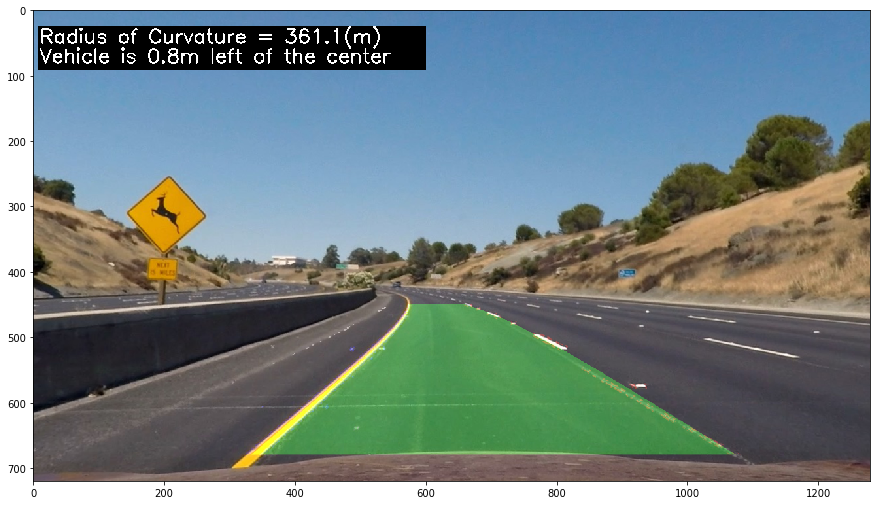

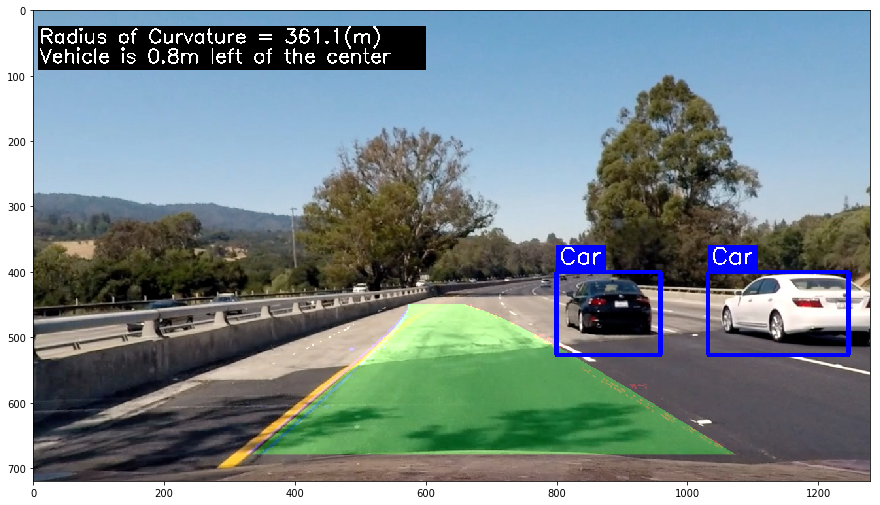

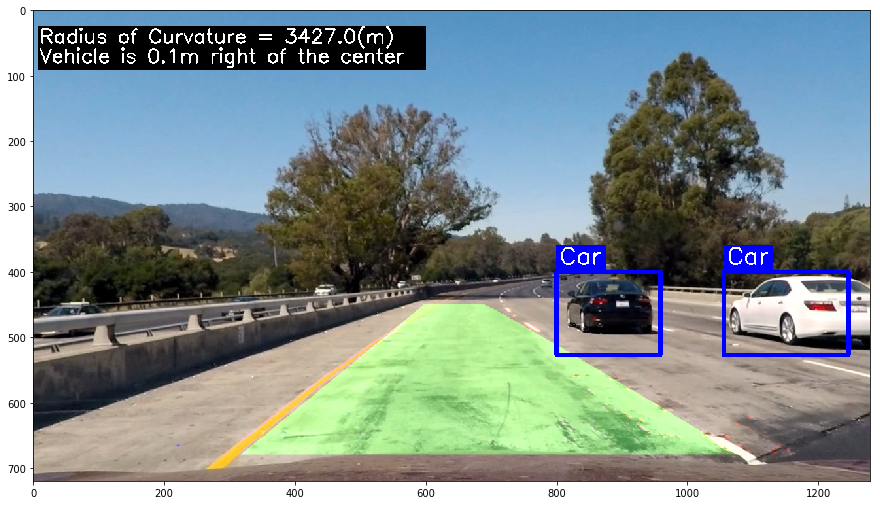

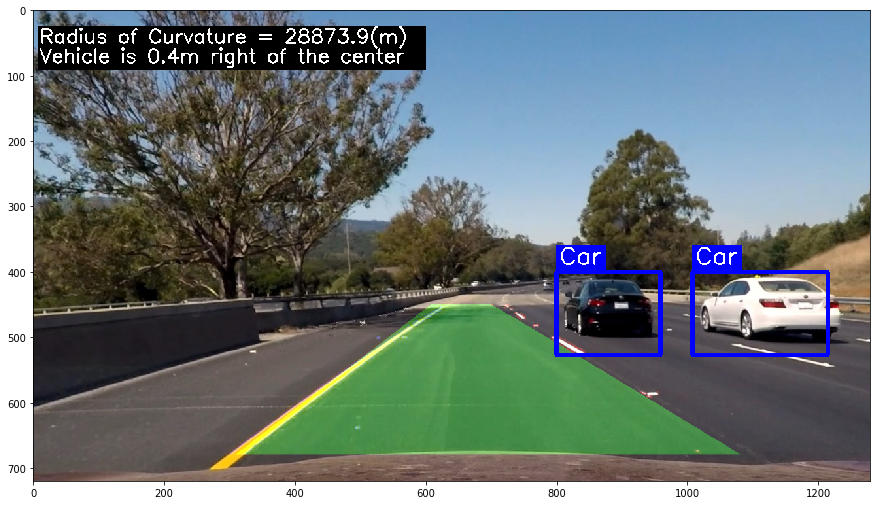

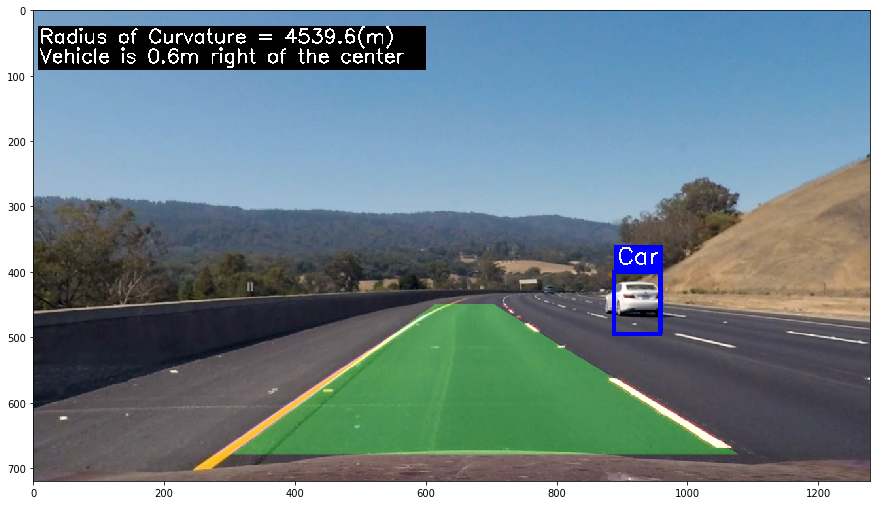

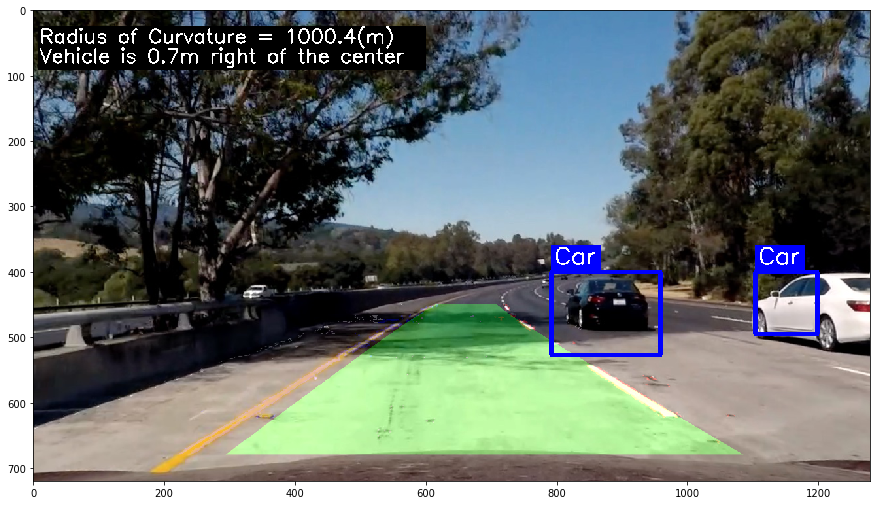

In [26]:
for img in test_img: 
    img = mpimg.imread(img)
    draw_img = obj.start(img)    
    fig, axes = plt.subplots(1,1, figsize=(15,15))            
    axes.imshow(draw_img)

In [27]:
#2-3(Case 2 Finish) Making Movie Clip for Case 2

from moviepy.editor import VideoFileClip
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from P4_Lane_Detection import Line
import pickle

clip = VideoFileClip("project_video.mp4")
output ="project_video_output_challenge.mp4"
output_clip = clip.fl_image(obj.start)
%time output_clip.write_videofile(output, audio=False)

Both curvature are not similar
Left: [ 2798.21803805]
Right: [ 1427.46337614]
[MoviePy] >>>> Building video project_video_output_challenge.mp4
[MoviePy] Writing video project_video_output_challenge.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

Both curvature are not similar
Left: [ 2798.21803805]
Right: [ 1427.46337614]


 25%|██▍       | 309/1261 [07:22<21:50,  1.38s/it]

Both curvature are not similar
Left: [ 1535.16463705]
Right: [ 1006.75306464]


 29%|██▉       | 364/1261 [08:39<20:51,  1.40s/it]

Both curvature are not similar
Left: [ 2193.55344375]
Right: [ 2838.55403429]


 29%|██▉       | 365/1261 [08:41<22:34,  1.51s/it]

Both curvature are not similar
Left: [ 1109.74955717]
Right: [ 1837.57251898]


 31%|███       | 389/1261 [09:15<18:19,  1.26s/it]

Both curvature are not similar
Left: [ 2989.62840011]
Right: [ 4624.62642499]


 35%|███▍      | 440/1261 [10:21<17:07,  1.25s/it]

Both curvature are not similar
Left: [ 2806.74181283]
Right: [ 4753.91473617]


 37%|███▋      | 466/1261 [10:55<16:51,  1.27s/it]

Both curvature are not similar
Left: [ 2946.11594835]
Right: [ 5173.12334055]


 42%|████▏     | 530/1261 [12:20<15:20,  1.26s/it]

Both curvature are not similar
Left: [ 2448.34131606]
Right: [ 18863.79271567]


 42%|████▏     | 531/1261 [12:21<15:18,  1.26s/it]

Both curvature are not similar
Left: [ 340.41484145]
Right: [ 855.73138532]


 42%|████▏     | 532/1261 [12:23<15:23,  1.27s/it]

Both curvature are not similar
Left: [ 332.12595552]
Right: [ 1126.87414194]


 43%|████▎     | 541/1261 [12:35<17:01,  1.42s/it]

Both curvature are not similar
Left: [ 397.36318637]
Right: [ 950.18225801]


 43%|████▎     | 542/1261 [12:36<16:23,  1.37s/it]

Both curvature are not similar
Left: [ 164.87672953]
Right: [ 1011.81956474]


 43%|████▎     | 543/1261 [12:37<16:31,  1.38s/it]

Both curvature are not similar
Left: [ 162.03429638]
Right: [ 1706.9966759]


 43%|████▎     | 544/1261 [12:39<16:24,  1.37s/it]

Both curvature are not similar
Left: [ 197.23707772]
Right: [ 872.54033296]


 43%|████▎     | 545/1261 [12:40<16:06,  1.35s/it]

Both curvature are not similar
Left: [ 184.16511214]
Right: [ 776.23771378]


 44%|████▎     | 550/1261 [12:48<19:30,  1.65s/it]

Both curvature are not similar
Left: [ 1225.83881521]
Right: [ 559.68632148]


 44%|████▍     | 554/1261 [12:55<18:34,  1.58s/it]

Both curvature are not similar
Left: [ 320.13297281]
Right: [ 1419.98518073]


 44%|████▍     | 555/1261 [12:56<18:19,  1.56s/it]

Both curvature are not similar
Left: [ 285.62013799]
Right: [ 1252.76645615]


 44%|████▍     | 556/1261 [12:58<18:18,  1.56s/it]

Both curvature are not similar
Left: [ 459.0687603]
Right: [ 1073.8615334]


 44%|████▍     | 558/1261 [13:01<18:25,  1.57s/it]

Both curvature are not similar
Left: [ 2612.91847211]
Right: [ 1725.68193016]


 44%|████▍     | 560/1261 [13:04<18:05,  1.55s/it]

Both curvature are not similar
Left: [ 1929.68183512]
Right: [ 844.92539562]


 45%|████▍     | 565/1261 [13:12<17:52,  1.54s/it]

Both curvature are not similar
Left: [ 1258.21306937]
Right: [ 3292.16330682]


 45%|████▍     | 566/1261 [13:13<18:03,  1.56s/it]

Both curvature are not similar
Left: [ 2492.84193737]
Right: [ 3443.00537798]


 45%|████▌     | 571/1261 [13:21<18:05,  1.57s/it]

Both curvature are not similar
Left: [ 2199.01888591]
Right: [ 954.39664938]


 45%|████▌     | 572/1261 [13:23<18:02,  1.57s/it]

Both curvature are not similar
Left: [ 2944.72735468]
Right: [ 969.56692399]


 46%|████▌     | 574/1261 [13:26<17:36,  1.54s/it]

Both curvature are not similar
Left: [ 1870.74336574]
Right: [ 1069.17545403]


 46%|████▌     | 575/1261 [13:27<17:33,  1.54s/it]

Both curvature are not similar
Left: [ 180.79083135]
Right: [ 1851.91706164]


 46%|████▌     | 576/1261 [13:29<17:37,  1.54s/it]

Both curvature are not similar
Left: [ 349.51868309]
Right: [ 16062.55481457]


 46%|████▌     | 577/1261 [13:30<17:27,  1.53s/it]

Both curvature are not similar
Left: [ 334.6735438]
Right: [ 3198.09694973]


 46%|████▌     | 578/1261 [13:31<16:24,  1.44s/it]

Both curvature are not similar
Left: [ 323.61379982]
Right: [ 3198.1634574]


 46%|████▌     | 579/1261 [13:33<17:21,  1.53s/it]

Both curvature are not similar
Left: [ 315.9366243]
Right: [ 3888.65191256]


 46%|████▌     | 580/1261 [13:35<17:14,  1.52s/it]

Both curvature are not similar
Left: [ 2524.45532613]
Right: [ 556.12212189]


 46%|████▌     | 581/1261 [13:36<17:00,  1.50s/it]

Both curvature are not similar
Left: [ 1327.32065476]
Right: [ 600.53944274]


 46%|████▌     | 582/1261 [13:37<16:40,  1.47s/it]

Both curvature are not similar
Left: [ 1098.47352028]
Right: [ 580.01941524]


 46%|████▋     | 585/1261 [13:41<15:14,  1.35s/it]

Both curvature are not similar
Left: [ 1485.75240374]
Right: [ 513.80079846]


 46%|████▋     | 586/1261 [13:43<14:50,  1.32s/it]

Both curvature are not similar
Left: [ 1167.21313731]
Right: [ 356.22229526]


 47%|████▋     | 589/1261 [13:46<14:14,  1.27s/it]

Both curvature are not similar
Left: [ 460.048113]
Right: [ 992.51640367]


 47%|████▋     | 591/1261 [13:49<14:06,  1.26s/it]

Both curvature are not similar
Left: [ 672.03242594]
Right: [ 1252.31046438]


 47%|████▋     | 594/1261 [13:53<13:55,  1.25s/it]

Both curvature are not similar
Left: [ 1022.18233244]
Right: [ 1691.88468147]


 47%|████▋     | 595/1261 [13:54<13:49,  1.25s/it]

Both curvature are not similar
Left: [ 829.31592463]
Right: [ 11861.28025351]


 47%|████▋     | 596/1261 [13:55<13:45,  1.24s/it]

Both curvature are not similar
Left: [ 708.42375868]
Right: [ 4804.01631755]


 47%|████▋     | 597/1261 [13:57<14:30,  1.31s/it]

Both curvature are not similar
Left: [ 890.92853969]
Right: [ 1982.29970454]


 47%|████▋     | 598/1261 [13:58<14:46,  1.34s/it]

Both curvature are not similar
Left: [ 876.88841487]
Right: [ 2371.18040229]


 48%|████▊     | 599/1261 [13:59<14:40,  1.33s/it]

Both curvature are not similar
Left: [ 2550.32444312]
Right: [ 911.7857937]


 77%|███████▋  | 969/1261 [22:17<06:28,  1.33s/it]

Both curvature are not similar
Left: [ 1632.79828518]
Right: [ 1080.44008816]


 77%|███████▋  | 972/1261 [22:21<06:27,  1.34s/it]

Both curvature are not similar
Left: [ 2540.23276079]
Right: [ 1703.26480839]


 78%|███████▊  | 978/1261 [22:30<06:48,  1.44s/it]

Both curvature are not similar
Left: [ 2937.05117662]
Right: [ 646.20323462]


 78%|███████▊  | 979/1261 [22:31<06:32,  1.39s/it]

Both curvature are not similar
Left: [ 851.03514754]
Right: [ 314.24416023]


 78%|███████▊  | 980/1261 [22:32<06:55,  1.48s/it]

Both curvature are not similar
Left: [ 1064.64293575]
Right: [ 5352.47199285]


 78%|███████▊  | 981/1261 [22:34<07:07,  1.53s/it]

Both curvature are not similar
Left: [ 780.39422793]
Right: [ 34032.33641944]


 78%|███████▊  | 982/1261 [22:35<06:43,  1.45s/it]

Both curvature are not similar
Left: [ 567.59278244]
Right: [ 3544.6785981]


 78%|███████▊  | 983/1261 [22:37<06:25,  1.39s/it]

Both curvature are not similar
Left: [ 870.28247642]
Right: [ 3132.4307308]


 78%|███████▊  | 985/1261 [22:39<06:02,  1.31s/it]

Both curvature are not similar
Left: [ 1205.24676858]
Right: [ 458.79416562]


 78%|███████▊  | 986/1261 [22:40<05:55,  1.29s/it]

Both curvature are not similar
Left: [ 1192.50733313]
Right: [ 526.0457716]


 78%|███████▊  | 988/1261 [22:43<05:59,  1.32s/it]

Both curvature are not similar
Left: [ 1559.78399971]
Right: [ 726.78646073]


 78%|███████▊  | 989/1261 [22:44<05:54,  1.30s/it]

Both curvature are not similar
Left: [ 1965.85540391]
Right: [ 822.24554521]


 79%|███████▊  | 991/1261 [22:47<05:47,  1.29s/it]

Both curvature are not similar
Left: [ 1008.7997672]
Right: [ 10869.56831325]


 79%|███████▊  | 992/1261 [22:48<05:41,  1.27s/it]

Both curvature are not similar
Left: [ 1263.35822677]
Right: [ 2667.85148103]


 79%|███████▊  | 993/1261 [22:49<05:45,  1.29s/it]

Both curvature are not similar
Left: [ 1188.27958382]
Right: [ 2051.75158747]


 79%|███████▉  | 994/1261 [22:51<05:51,  1.32s/it]

Both curvature are not similar
Left: [ 627.7981802]
Right: [ 1220.07020814]


 79%|███████▉  | 995/1261 [22:52<05:50,  1.32s/it]

Both curvature are not similar
Left: [ 517.4592]
Right: [ 1240.88699141]


 80%|████████  | 1013/1261 [23:15<05:29,  1.33s/it]

Both curvature are not similar
Left: [ 997.69134588]
Right: [ 411.70644628]


 80%|████████  | 1015/1261 [23:19<06:04,  1.48s/it]

Both curvature are not similar
Left: [ 1393.57374112]
Right: [ 360.03041745]


 81%|████████  | 1016/1261 [23:20<06:11,  1.51s/it]

Both curvature are not similar
Left: [ 1582.749627]
Right: [ 621.8196946]


 81%|████████  | 1017/1261 [23:22<05:50,  1.44s/it]

Both curvature are not similar
Left: [ 1808.54377824]
Right: [ 486.31058834]


 81%|████████  | 1018/1261 [23:23<05:41,  1.41s/it]

Both curvature are not similar
Left: [ 1205.97868224]
Right: [ 456.88649288]


 81%|████████  | 1019/1261 [23:25<05:59,  1.48s/it]

Both curvature are not similar
Left: [ 1117.31550217]
Right: [ 443.22579575]


 83%|████████▎ | 1045/1261 [24:03<05:40,  1.57s/it]

Both curvature are not similar
Left: [ 363.22162109]
Right: [ 901.2638524]


 88%|████████▊ | 1113/1261 [25:35<03:44,  1.52s/it]

Both curvature are not similar
Left: [ 1090.4592707]
Right: [ 532.71309214]


 88%|████████▊ | 1114/1261 [25:36<03:30,  1.43s/it]

Both curvature are not similar
Left: [ 1669.47897892]
Right: [ 412.39626996]


 88%|████████▊ | 1115/1261 [25:37<03:21,  1.38s/it]

Both curvature are not similar
Left: [ 1492.40163264]
Right: [ 449.13330914]


 89%|████████▊ | 1116/1261 [25:39<03:14,  1.34s/it]

Both curvature are not similar
Left: [ 1221.37278399]
Right: [ 472.20956233]


 89%|████████▊ | 1117/1261 [25:40<03:09,  1.32s/it]

Both curvature are not similar
Left: [ 1196.59575141]
Right: [ 619.15317664]


 89%|████████▊ | 1118/1261 [25:41<03:05,  1.30s/it]

Both curvature are not similar
Left: [ 1323.0926484]
Right: [ 617.71706419]


 91%|█████████ | 1145/1261 [26:16<02:28,  1.28s/it]

Both curvature are not similar
Left: [ 1259.27936182]
Right: [ 735.81735089]


 91%|█████████ | 1146/1261 [26:17<02:25,  1.27s/it]

Both curvature are not similar
Left: [ 1299.50181552]
Right: [ 450.9336986]


 91%|█████████ | 1147/1261 [26:19<02:22,  1.25s/it]

Both curvature are not similar
Left: [ 1089.30390604]
Right: [ 459.55577538]


 91%|█████████ | 1148/1261 [26:20<02:25,  1.29s/it]

Both curvature are not similar
Left: [ 1044.73590616]
Right: [ 478.28978227]


 91%|█████████ | 1149/1261 [26:21<02:26,  1.31s/it]

Both curvature are not similar
Left: [ 1003.86021451]
Right: [ 484.24758013]


 91%|█████████ | 1150/1261 [26:23<02:24,  1.30s/it]

Both curvature are not similar
Left: [ 1316.70028646]
Right: [ 509.43524875]


 91%|█████████▏| 1151/1261 [26:24<02:20,  1.28s/it]

Both curvature are not similar
Left: [ 1295.5929744]
Right: [ 596.72269745]


 93%|█████████▎| 1179/1261 [27:02<01:46,  1.29s/it]

Both curvature are not similar
Left: [ 1233.60622694]
Right: [ 688.15450489]


 94%|█████████▎| 1180/1261 [27:03<01:43,  1.28s/it]

Both curvature are not similar
Left: [ 1016.21008794]
Right: [ 498.04989714]


 97%|█████████▋| 1227/1261 [28:05<00:44,  1.30s/it]

Both curvature are not similar
Left: [ 1073.7519949]
Right: [ 567.40484736]


 97%|█████████▋| 1228/1261 [28:06<00:43,  1.31s/it]

Both curvature are not similar
Left: [ 1415.78585123]
Right: [ 561.61219546]


 97%|█████████▋| 1229/1261 [28:08<00:42,  1.31s/it]

Both curvature are not similar
Left: [ 1468.92063185]
Right: [ 828.21677263]


 98%|█████████▊| 1230/1261 [28:09<00:40,  1.30s/it]

Both curvature are not similar
Left: [ 1448.27790637]
Right: [ 720.27097172]


 98%|█████████▊| 1231/1261 [28:10<00:38,  1.29s/it]

Both curvature are not similar
Left: [ 1479.91324764]
Right: [ 773.35620275]


 98%|█████████▊| 1236/1261 [28:17<00:35,  1.40s/it]

Both curvature are not similar
Left: [ 2545.96949117]
Right: [ 1630.31162625]


 98%|█████████▊| 1240/1261 [28:22<00:27,  1.31s/it]

Both curvature are not similar
Left: [ 2794.55697396]
Right: [ 1109.92651251]


 98%|█████████▊| 1241/1261 [28:24<00:27,  1.35s/it]

Both curvature are not similar
Left: [ 2661.32394513]
Right: [ 1859.97082663]


 99%|█████████▊| 1244/1261 [28:28<00:24,  1.44s/it]

Both curvature are not similar
Left: [ 2771.05666546]
Right: [ 4116.02094957]


100%|█████████▉| 1260/1261 [28:49<00:01,  1.27s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_challenge.mp4 

CPU times: user 31min 33s, sys: 4.88 s, total: 31min 38s
Wall time: 28min 51s
